## Auswertung Zisterne Datenfiles
Datenfiles aus Zisternen-Controller auswerten

Remarks:<br>
11.05.19 Filterreinigung<br>
21.05.19 Anpassung Filterüberlauf von 203cm auf 183cm

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import requests
from IPython.display import IFrame
import datetime
import re
from sklearn import tree

### Daten einlesen

In [2]:
# Datensammlung einlesen
df1=pd.read_csv('Datensammlung.csv',engine='python',sep=';',decimal=',',index_col=False)
df1['Timestamp']=pd.to_datetime(df1['Date'],format='%d.%m.%Y %H:%M')
#Umbenennung falsche Spaltennamen
df1=df1.rename(columns={"Measured quantity change 24h [Liter]": "Measured quantity change 1h [Liter]", "Calculated quantity change 24h [Liter]": "Calculated quantity change 1h [Liter]", "Refill quantity 24h [Liter]":"Refill quantity 1h [Liter]"})
df1.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
629,181203_V310_4.csv,03.12.2018 16:17,1097,3446,98,Kein Fehler erkannt,1.51,180,14.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-03 16:17:00
630,181203_V310_4.csv,03.12.2018 17:17,1136,3568,100,Kein Fehler erkannt,0.00,180,16.23,0.0,122.0,156.0,21.0,Verstopft,NaN,NaN,2018-12-03 17:17:00
631,181203_V310_4.csv,03.12.2018 18:17,1221,3835,98,Kein Fehler erkannt,1.81,180,18.00,0.0,267.0,157.0,0.0,OK,NaN,NaN,2018-12-03 18:17:00
632,181203_V310_4.csv,03.12.2018 19:17,1330,4178,100,Kein Fehler erkannt,0.00,180,20.65,0.0,343.0,244.0,0.0,OK,NaN,NaN,2018-12-03 19:17:00
633,181203_V310_4.csv,03.12.2018 20:17,1437,4514,100,Kein Fehler erkannt,0.00,180,22.72,0.0,336.0,186.0,0.0,OK,NaN,NaN,2018-12-03 20:17:00


### Weitere Daten lesen ab 3.12.18
Alle Daten befinden sich im unterverzeichnis ./csv. Die obigen Daten stehen im ./bak verzeichnis

In [3]:
# Aktuelle Web-Page darstellen 
IFrame(src='http://192.168.178.5', width=700, height=800)

Erst mal neue Daten lesen

In [4]:
# Programm Version bestimmen 
#<H2>Programminfo</h2><p>V3.1.0</p>
response = requests.get('http://192.168.178.5')
base_text = response.text
base_text=base_text.replace('\n','')
base_text=base_text.replace('\r','')
#x = re.match('.*<H2>Programminfo</h2><p>(\S*)</p>.*', base_text) 
x = re.search('(?<=<H2>Programminfo</h2><p>)(\S+)(?=</p>)', base_text) 
version=x.group(0)
version=version.replace('.','')

# Get data log file
response = requests.get('http://192.168.178.5/Res_Ctl.csv')
data = response.text
data=data.replace('\r\r','\r')
if (len(re.findall('\r\n',data))>1):
    filename="csv/"+datetime.datetime.now().strftime("%y%m%d%H%M%S")+"_"+version+".csv"
    text_file = open(filename, "w")
    text_file.write("%s" % data)
    text_file.close()
    print("New file saved: "+filename)
else:
    print("Received file is empty and will not be saved")
    
# Get system log file
response = requests.get('http://192.168.178.5/Res_Ctl.log')
data = response.text
data=data.replace('\r\r','\r')
if (len(re.findall('\r\n',data))>1):
    filename="log/"+datetime.datetime.now().strftime("%y%m%d%H%M%S")+"_"+version+".log"
    text_file = open(filename, "w")
    text_file.write("%s" % data)
    text_file.close()
    print("New file saved: "+filename)
else:
    print("Received file is empty and will not be saved")    

    

New file saved: csv/190606165459_V423.csv
New file saved: log/190606165635_V423.log


In [5]:
# Dateien listen
newfiles=os.listdir('./csv')
#newfiles

In [6]:
#Dataframe mit allen Daten erstellen
df=df1
for nFile in newfiles:
    df2=pd.read_csv('./csv/'+nFile,engine='python',sep=';',decimal='.',index_col=False)    
    df2=df2.rename(columns={"Measured quantity change 24h [Liter]": "Measured quantity change 1h [Liter]", "Calculated quantity change 24h [Liter]": "Calculated quantity change 1h [Liter]", "Refill quantity 24h [Liter]":"Refill quantity 1h [Liter]"})
    df2.insert(0,'Log File',nFile)
    df2['Timestamp']=pd.to_datetime(df2['Date'],format='%Y-%m-%d %H:%M:%S')
    df=df.append(df2,sort=False)
df.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
379,190606165459_V423.csv,2019-06-06 12:34:05,1278,4014,100,Kein Fehler erkannt,0.00,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-06 12:34:05
380,190606165459_V423.csv,2019-06-06 13:34:14,1277,4011,98,Kein Fehler erkannt,1.30,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-06 13:34:14
381,190606165459_V423.csv,2019-06-06 14:34:23,1271,3992,100,Kein Fehler erkannt,0.00,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-06 14:34:23
382,190606165459_V423.csv,2019-06-06 15:34:30,1271,3992,100,Kein Fehler erkannt,0.00,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-06 15:34:30
383,190606165459_V423.csv,2019-06-06 16:34:39,1270,3989,99,Kein Fehler erkannt,0.85,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-06 16:34:39


In [7]:
df.describe()

,Level [mm],Quantity [Liter],Signal health [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Usage in last 24h [Liter],Usage average in last 10d [Liter]
count,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,4885.000000,53.000000,53.000000,53.000000,53.000000,63.00000,63.000000
mean,1138.445007,3576.044220,98.353569,1.317680,1246.265692,18.539275,1.509434,168.452830,195.264151,24.943396,137.31746,122.317460
std,657.755954,2066.411501,3.219943,2.391808,1929.378569,38.740288,6.620547,127.855773,101.770887,33.848313,131.95146,93.562955
min,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,-34.000000,89.000000,0.000000,-36.00000,18.000000
25%,380.000000,1193.000000,98.000000,0.000000,20.000000,0.000000,0.000000,110.000000,126.000000,0.000000,44.50000,64.500000
50%,1517.000000,4765.000000,99.000000,0.620000,60.000000,0.890000,0.000000,138.000000,159.000000,0.000000,87.00000,83.000000
75%,1728.000000,5428.000000,100.000000,1.520000,2500.000000,12.100000,0.000000,214.000000,219.000000,45.000000,255.50000,135.500000
max,1841.000000,5783.000000,100.000000,94.370000,4840.000000,138.400000,40.000000,549.000000,480.000000,116.000000,445.00000,330.000000


### Formatumwandlungen

In [8]:
# Daten mit 1.1.70 entfernen
df=df[(df['Timestamp']>'1970-01-01 12:00:00')]

#set date as index
df.set_index('Timestamp',inplace=True)

#Strings ersetzen
df['Filter diagnosis [-]']=df['Filter diagnosis [-]'].replace('OK',1)
df['Filter diagnosis [-]']=df['Filter diagnosis [-]'].replace('Verstopft',0)


### Stündliche Regenmenge rechnen

In [9]:
df['Rain quantity 1h [Liter]']=df['Rain quantity 24h [Liter]'].diff()
df['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]'].clip(lower=0)
df.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Rain quantity 1h [Liter]
Timestamp,,,,,,,,,,,,,,,,,
2019-06-06 12:34:05,190606165459_V423.csv,2019-06-06 12:34:05,1278,4014,100,Kein Fehler erkannt,0.00,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2019-06-06 13:34:14,190606165459_V423.csv,2019-06-06 13:34:14,1277,4011,98,Kein Fehler erkannt,1.30,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2019-06-06 14:34:23,190606165459_V423.csv,2019-06-06 14:34:23,1271,3992,100,Kein Fehler erkannt,0.00,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2019-06-06 15:34:30,190606165459_V423.csv,2019-06-06 15:34:30,1271,3992,100,Kein Fehler erkannt,0.00,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2019-06-06 16:34:39,190606165459_V423.csv,2019-06-06 16:34:39,1270,3989,99,Kein Fehler erkannt,0.85,4840,138.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### Datensatz zerlegen 
1. Grunddaten Pegel, Menge, Nachspeisung, Regen

In [10]:
# 1. Grunddaten
dfg=df.iloc[:,0:9]
dfg.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter]
Timestamp,,,,,,,,,
2019-06-06 12:34:05,190606165459_V423.csv,2019-06-06 12:34:05,1278,4014,100,Kein Fehler erkannt,0.00,4840,138.4
2019-06-06 13:34:14,190606165459_V423.csv,2019-06-06 13:34:14,1277,4011,98,Kein Fehler erkannt,1.30,4840,138.4
2019-06-06 14:34:23,190606165459_V423.csv,2019-06-06 14:34:23,1271,3992,100,Kein Fehler erkannt,0.00,4840,138.4
2019-06-06 15:34:30,190606165459_V423.csv,2019-06-06 15:34:30,1271,3992,100,Kein Fehler erkannt,0.00,4840,138.4
2019-06-06 16:34:39,190606165459_V423.csv,2019-06-06 16:34:39,1270,3989,99,Kein Fehler erkannt,0.85,4840,138.4


2. Filter-Diagnosedaten

In [11]:
# 2. Filter-Diagnosedaten
# Werte auswaehlen
dfd=df.iloc[:, 1:14]
dfd['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]']
dfd_failed=dfd.where(dfd['Filter diagnosis [-]']==0).dropna(axis=0,how='all')
dfd_ok = dfd.where(dfd['Filter diagnosis [-]']==1).dropna(axis=0,how='all')
dfd_all=pd.concat([dfd_failed, dfd_ok])
dfd_all.sort_values('Timestamp')
dfd_all.tail(20)

,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter]
Timestamp,,,,,,,,,,,,,,
2018-12-04 05:19:12,2018-12-04 05:19:12,1617.0,5079.0,100.0,Kein Fehler erkannt,0.00,180.0,27.44,0.0,128.0,97.0,0.0,1.0,1.18
2018-12-06 01:25:15,2018-12-06 01:25:15,1673.0,5255.0,100.0,Kein Fehler erkannt,0.00,180.0,1.77,0.0,144.0,127.0,0.0,1.0,1.47
2018-12-07 20:31:10,2018-12-07 20:31:10,1709.0,5368.0,100.0,Kein Fehler erkannt,0.00,180.0,1.18,0.0,84.0,97.0,13.0,1.0,1.18
2018-12-09 00:35:01,2018-12-09 00:35:01,1751.0,5500.0,95.0,Kein Fehler erkannt,5.09,180.0,2.07,0.0,100.0,97.0,0.0,1.0,1.18
2019-02-10 18:03:30,2019-02-10 18:03:30,1626.0,5108.0,100.0,Kein Fehler erkannt,0.00,40.0,4.13,0.0,138.0,98.0,0.0,1.0,1.18
2019-03-01 02:03:23,2019-03-01 02:03:23,1357.0,4263.0,100.0,Kein Fehler erkannt,0.00,40.0,2.07,0.0,145.0,97.0,0.0,1.0,1.18
2019-03-01 08:59:08,2019-03-01 08:59:08,1567.0,4922.0,100.0,Kein Fehler erkannt,0.00,40.0,11.51,0.0,220.0,215.0,0.0,1.0,2.36
2019-05-18 15:54:50,2019-05-18 15:54:50,540.0,1696.0,100.0,Kein Fehler erkannt,0.00,4820.0,73.80,0.0,138.0,130.0,0.0,1.0,1.50
2019-05-20 01:59:29,2019-05-20 01:59:29,602.0,1891.0,98.0,Kein Fehler erkannt,1.55,4820.0,80.80,0.0,189.0,149.0,0.0,1.0,1.70


3. Verbrauchsberechnung

In [12]:
# 3. Verbrauchsdaten
dfv=df.iloc[:,14:16]

#Werte kleiner Null abschneiden (SW-Fehler)
dfv['Usage in last 24h [Liter]']=dfv['Usage in last 24h [Liter]'].clip(lower=0)
dfv['Usage average in last 10d [Liter]']=dfv['Usage average in last 10d [Liter]'].clip(lower=0)
dfv=dfv.where(dfv['Usage in last 24h [Liter]']>0)
# NaNs entfernen
dfv=dfv.dropna(axis=0,how='any')
dfv.tail()

,Usage in last 24h [Liter],Usage average in last 10d [Liter]
Timestamp,,
2019-04-08 02:02:12,348.0,322.0
2019-04-09 02:05:28,285.0,329.0
2019-04-10 02:08:45,266.0,330.0
2019-04-11 02:12:01,60.0,291.0
2019-04-13 02:18:32,312.0,283.0


### Pegeldaten analysieren

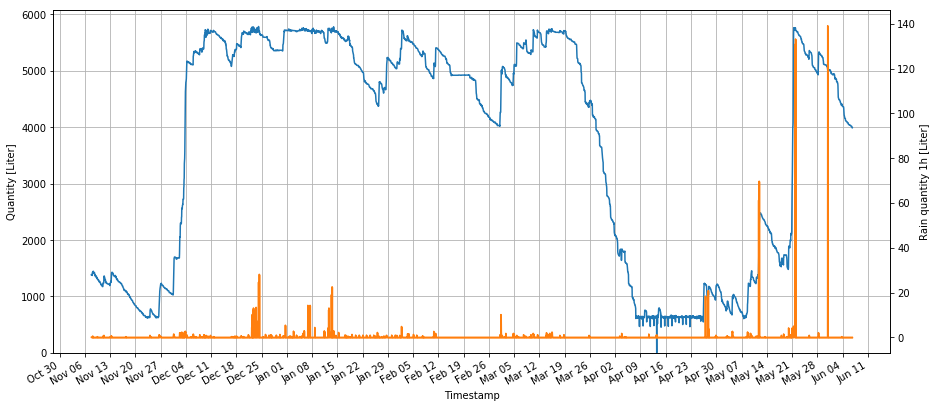

In [13]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
df['Quantity [Liter]'].plot(ax=ax,grid=True)
df['Rain quantity 1h [Liter]'].plot(ax=ax,grid=True,secondary_y=True,kind='area')

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_ylabel('Quantity [Liter]')
plt.ylabel('Rain quantity 1h [Liter]');


### Filter-Diagnose analysieren

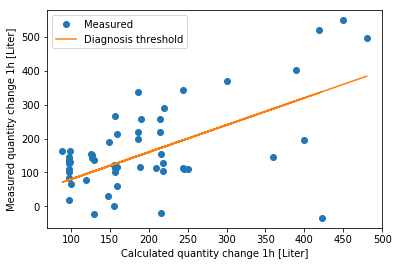

In [14]:
plt.plot(dfd_all['Calculated quantity change 1h [Liter]'],dfd_all['Measured quantity change 1h [Liter]'],'o')
plt.plot(dfd_all['Calculated quantity change 1h [Liter]'],0.8*dfd_all['Calculated quantity change 1h [Liter]'])
plt.xlabel('Calculated quantity change 1h [Liter]')
plt.ylabel('Measured quantity change 1h [Liter]')
plt.legend({'Measured','Diagnosis threshold'});

### Fehlerhafte Datenpunkte
Filterverstopfung angezeigt aber tatsächlich nicht verstopft

In [15]:
numPntsOK = dfd_ok.Date.count()
numPntsFailed = dfd_failed.Date.count()
numPntsTot=numPntsFailed+numPntsOK
print("Korrekt erkannte OK-Fälle   : ", numPntsOK, " (", 100*numPntsOK/numPntsTot, "%)")
print("Fehlerhaft erkannte OK-Fälle: ", numPntsFailed, " (", 100*numPntsFailed/numPntsTot, "%)")


Korrekt erkannte OK-Fälle   :  30  ( 56.60377358490566 %)
Fehlerhaft erkannte OK-Fälle:  23  ( 43.39622641509434 %)


In [16]:
dfd_failed.head(20)
#Manuelle Analyse: 
#2018-12-22 20:44:12 Speicher voll aber Diagnose noch aktiv --> behoben in SW durch größeres Band 
#2018-12-22 06:03:12 Speicher voll aber Diagnose noch aktiv --> behoben in SW durch größeres Band 
#2018-12-21 08:00:18 Speicher voll aber Diagnose noch aktiv --> behoben in SW durch größeres Band 
#2018-12-02 19:14:00 geringe Überschreitung
#2018-12-02 21:14:00 geringe Überschreitung, Starkregen
#2018-12-03 17:17:00 geringe Überschreitung
#2018-12-03 21:18:06 Starkregen
#2019-02-10 17:03:22 Starkregen

,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter]
Timestamp,,,,,,,,,,,,,,
2018-12-02 19:14:00,02.12.2018 19:14,766.0,2406.0,98.0,Kein Fehler erkannt,1.56,180.0,7.97,0.0,113.0,157.0,28.0,0.0,1.77
2018-12-02 21:14:00,02.12.2018 21:14,816.0,2563.0,100.0,Kein Fehler erkannt,0.00,180.0,10.33,0.0,154.0,216.0,28.0,0.0,2.36
2018-12-03 17:17:00,03.12.2018 17:17,1136.0,3568.0,100.0,Kein Fehler erkannt,0.00,180.0,16.23,0.0,122.0,156.0,21.0,0.0,1.77
2018-12-03 21:18:06,2018-12-03 21:18:06,1473.0,4627.0,100.0,Kein Fehler erkannt,0.00,180.0,25.37,0.0,113.0,244.0,53.0,0.0,2.65
2018-12-21 08:00:18,2018-12-21 08:00:18,1806.0,5673.0,100.0,Kein Fehler erkannt,0.00,180.0,1.48,0.0,19.0,98.0,80.0,0.0,1.18
2018-12-22 06:03:12,2018-12-22 06:03:12,1810.0,5686.0,94.0,Kein Fehler erkannt,5.90,180.0,6.49,0.0,-34.0,422.0,108.0,0.0,4.42
2018-12-22 20:44:12,2018-12-22 20:44:12,1826.0,5736.0,100.0,Kein Fehler erkannt,0.00,0.0,19.47,0.0,-19.0,216.0,108.0,0.0,2.36
2019-02-10 17:03:22,2019-02-10 17:03:22,1582.0,4970.0,98.0,Kein Fehler erkannt,1.49,40.0,2.95,0.0,110.0,245.0,55.0,0.0,2.65
2019-03-02 16:03:22,2019-03-02 16:03:22,1566.0,4919.0,100.0,Kein Fehler erkannt,0.00,60.0,2.65,0.0,0.0,155.0,100.0,0.0,1.76


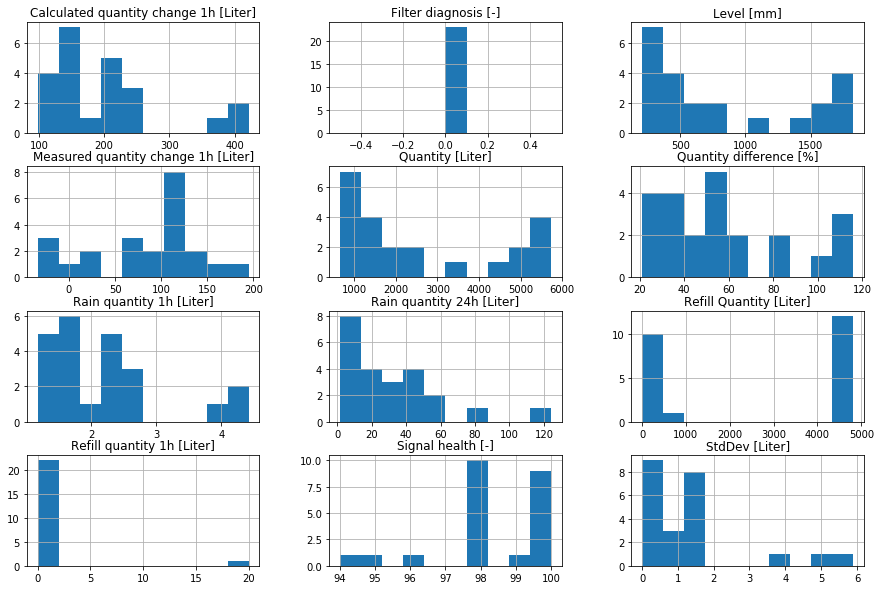

In [17]:
dfd_failed.hist(figsize=[15, 10]);

In [18]:
#dfd_ok.tail()

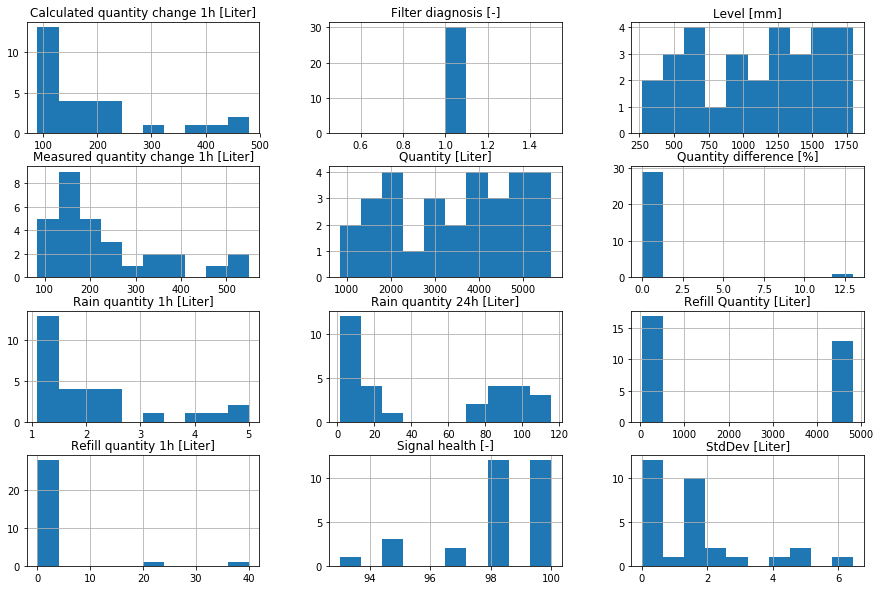

In [19]:
dfd_ok.hist(figsize=[15, 10]);

### Aufsummierte Regenmenge

### Filtereffizienz

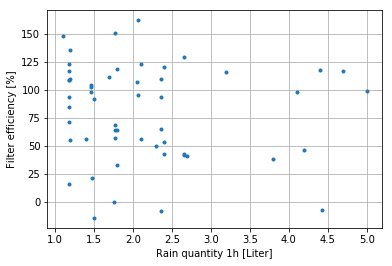

In [20]:
aRoof = 100
dfd["rEffFlt [%]"] = 100*(dfd["Measured quantity change 1h [Liter]"]/(dfd["Rain quantity 1h [Liter]"]*aRoof))
plt.plot(dfd["Rain quantity 1h [Liter]"],dfd["rEffFlt [%]"],'.');
plt.xlabel('Rain quantity 1h [Liter]')
plt.ylabel('Filter efficiency [%]')
plt.grid()

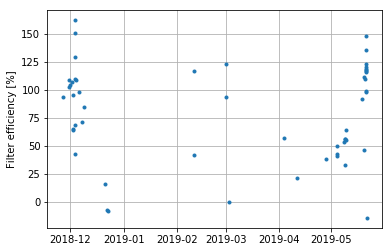

In [21]:
plt.plot(dfd["rEffFlt [%]"],'.');

plt.ylabel('Filter efficiency [%]')
plt.grid()

In [22]:
dfd_all=dfd.dropna(axis=0,how='any')
dfd_all.tail(20)

,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter],rEffFlt [%]
Timestamp,,,,,,,,,,,,,,,
2019-05-08 17:47:16,2019-05-08 17:47:16,307,964,98,Kein Fehler erkannt,1.26,4820,45.1,0.0,79.0,119.0,33.0,0.0,1.4,56.428571
2019-05-08 19:47:32,2019-05-08 19:47:32,346,1086,99,Kein Fehler erkannt,0.94,4820,47.8,0.0,59.0,159.0,62.0,0.0,1.8,32.777778
2019-05-08 20:47:41,2019-05-08 20:47:41,383,1203,98,Kein Fehler erkannt,1.15,4820,49.9,0.0,117.0,189.0,38.0,0.0,2.1,55.714286
2019-05-09 11:49:44,2019-05-09 11:49:44,415,1303,98,Kein Fehler erkannt,1.09,4820,52.2,0.0,116.0,159.0,27.0,0.0,1.8,64.444444
2019-05-09 14:50:08,2019-05-09 14:50:08,434,1363,100,Kein Fehler erkannt,0.00,4820,53.4,0.0,66.0,100.0,34.0,0.0,1.2,55.000000
2019-05-18 15:54:50,2019-05-18 15:54:50,540,1696,100,Kein Fehler erkannt,0.00,4820,73.8,0.0,138.0,130.0,0.0,1.0,1.5,92.000000
2019-05-20 00:59:20,2019-05-20 00:59:20,542,1702,98,Kein Fehler erkannt,1.54,4820,79.1,0.0,195.0,399.0,51.0,0.0,4.2,46.428571
2019-05-20 01:59:29,2019-05-20 01:59:29,602,1891,98,Kein Fehler erkannt,1.55,4820,80.8,0.0,189.0,149.0,0.0,1.0,1.7,111.176471
2019-05-20 16:01:24,2019-05-20 16:01:24,674,2117,100,Kein Fehler erkannt,0.00,4820,83.8,0.0,132.0,99.0,0.0,1.0,1.2,110.000000


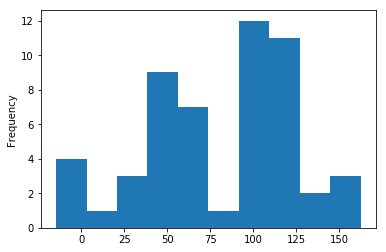

In [23]:
dfd["rEffFlt [%]"].plot(kind='hist')

### Verbrauchsberechnung

In [24]:
dfv.tail(10)

,Usage in last 24h [Liter],Usage average in last 10d [Liter]
Timestamp,,
2019-04-01 02:39:26,403.0,300.0
2019-04-02 02:42:43,249.0,320.0
2019-04-03 02:45:59,354.0,323.0
2019-04-06 02:55:48,352.0,320.0
2019-04-07 02:59:03,201.0,311.0
2019-04-08 02:02:12,348.0,322.0
2019-04-09 02:05:28,285.0,329.0
2019-04-10 02:08:45,266.0,330.0
2019-04-11 02:12:01,60.0,291.0


In [25]:
dfv.describe()

,Usage in last 24h [Liter],Usage average in last 10d [Liter]
count,57.000000,57.000000
mean,154.350877,129.070175
std,127.098456,95.710288
min,11.000000,28.000000
25%,60.000000,66.000000
50%,92.000000,85.000000
75%,266.000000,164.000000
max,445.000000,330.000000


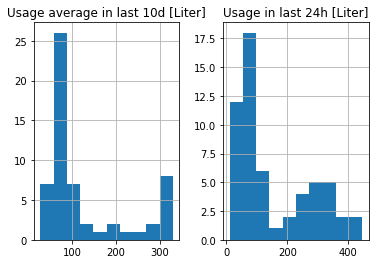

In [26]:
dfv.hist();

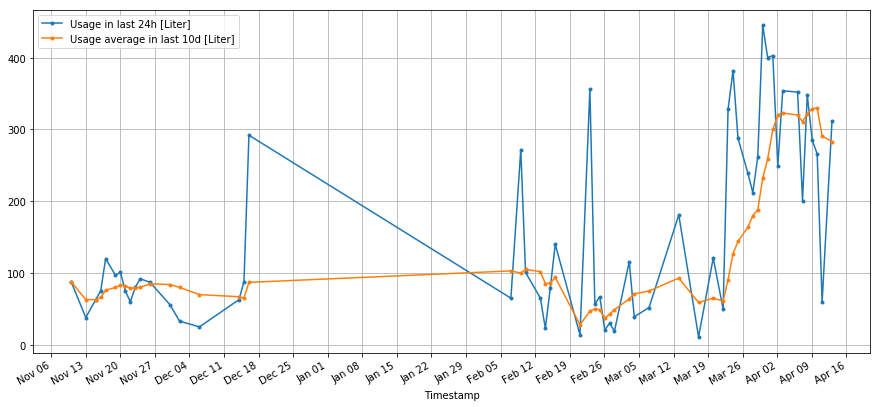

In [27]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
dfv.plot(ax=ax,grid=True,style='.-')

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
